# Lab 4 - SoC-FPGA DAQ system and TCL
This Jupyter Notebook (JN) is the continuation of the Lab guide that will take you through the necessary steps to interact with the ZedBoard development board via Ethernet using the UDMA framework. All the provided source code is written in Python 3.

In this Lab exercise you will not only interact with the design in the Zynq SoC, but also with the external DAC and ADC boards plugged into the ZedBoard PMOD connectors. To do so, we have prepared an environment based on Python 3.8 and the required libraries to execute the workflow described next:

1) **Python**
  - Synthesize periodic signals (waveforms) as individual samples, represented by a numeric array 
2) **Python + UDMA <---> Zynq SoC**
  - Send from this JN to the ComBlock's DP-RAM the waveform individual samples that represent the DAC output
  - Use the UDMA library to write individual ComBlock output registers to setup the ADC and DAC driver values
  - Use the UDMA library to read the contents of the data stored in the ComBlock's FIFO
3) **Python**
  - Assess the contents of the data read from the ComBlock's FIFO with the expected behavior of the FIR filter within the programmable logic design in the SoC

All the required steps are documented in this JN, so you can easily follow them along with the code you execute in the notebook blocks.

---

- Author(s): Ivan Morales (MLab/ICTP) - 2023/10/31 (version 1.0)
- Update(s):

---

## Importing libraries


In [2]:
# Setting up plot rendering handler for Jupyter Notebook
%matplotlib widget

# == MLab libraries ==
import udma #MLab UDMA library
from waveforms import Waveforms #MLab waveform synthesis library

# Other libraries
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import time

# 1) Python signal synthesis

## Synthetic waveforms library

Using the 'waveforms' library to generate the stimuli sent to the hardware platform (ZedBoard).

The generated data in this step will be further sent to be stored in ComBlock DP-RAM and automatically fetched out through the DAC (PMOD-DA1) analog output.

Both the ADC and DAC operate at 1 MHz, leading to a Nyquist theoretical limit of 500 kHz. Since no antialiasing nor reconstruction filters are used, the practical frequency limit for the waveforms is considerably reduced: we recommend you not to exceed **50 kHz** to get a _recognizable_ signal shape.

The library provides four types of periodic waveforms using the ```computeWaveform``` method:
- Sinusoidal
- Sawtooth
- Square
- Noise (white Gaussian)

Also, a _chirp_-like waveform can be generated using the ```computeSweep``` method. A sinusoidal signal with a frequency sweep is generated, according to the provided frequency limits as parameters.

In [3]:
'''
 We define the global signal synthesis parameters here:
 do not change them if not sure about their behavior.
''' 

# Total trace length (samples). This value must match the Vivado Block Design settings.
TRACE_LEN = 4096

# ADC and DAC sampling rate
SAMPLING_RATE = 1e6 # 1e6 = 1x10^6 = 1 MHz

# Data must be split to be sent in chunks/packets via UDMA to avoid TCP segmentation
TRACE_SEGMENTS = 32 # Do not change this value
CHUNK_SIZE = TRACE_LEN//TRACE_SEGMENTS # Must be always smaller than 250 elements

### Initializing the waveform synthesis library

We are creating an instance of the **Waveforms** library. The initialization is carried out only once.

The instance name is ```wf```: this is the element you will be interacting with to generate the waveforms.

In [4]:
# Creating the waveforms library instance

wf = Waveforms(length = TRACE_LEN, # Number of samples of each waveform
               samplingFreq = SAMPLING_RATE, # Sampling frequency of the ADC and DAQ 
               dacBits = 8)        # Resolution (bits) of the DAC

### Waveform synthesis

Here you will synthesize multiple waveforms and plot them to easily identify their properties.

Please, **do not** exceed the Nyquist limit (500 kHz) in any case.


#### Periodic waveform parameters
The waveform synthesis library is capable of generating periodic signals, according to the provided parameters.

To generate a periodic waveform, the ```computeWaveform``` method is used. If you not provide any parameter, the following waveform will be generated by default:
- Waveform: 'sine'
- Frequency: 10 kHz
- Amplitude: 250 (DAC step units)

Since the DAC resolution is 8 bits, the maximum supported amplitude value is **255** ($2^8 - 1$).

As a starting point, we provide to you two waveforms:
- A 20 kHz sinewave with amplitude 200
- A _frequency-sweep_ sinewave with a frequency range from 5 kHz to 50 kHz and constant amplitude 250.

#### List of available periodic waveforms
Executing the next code block will generate a list of the available waveforms in the library when using the ```computeWaveform``` method. Use **only** these names to generate the periodic waveforms that will be requested in the further steps.

In [5]:
wf.getListOfWaveforms()

['sine', 'sawtooth', 'square', 'noise']

#### 20 kHz sinewave

This waveform is synthesized with a frequency _close_ to 20 kHz, but not exactly: the actual frequency value es 19531 Hz. Can you imagine why this _non-round_ value was chosen? Let the instructors know any thoughts about this particular frequency.

__Hint__: You're about to store this array of samples (waveform) in a 4096-element RAM that will emulate an arbitrary waveform generator. 


The resulting waveform is stored in the variable ```sineWave20k``` as an array (list) of 4096 integer elements.

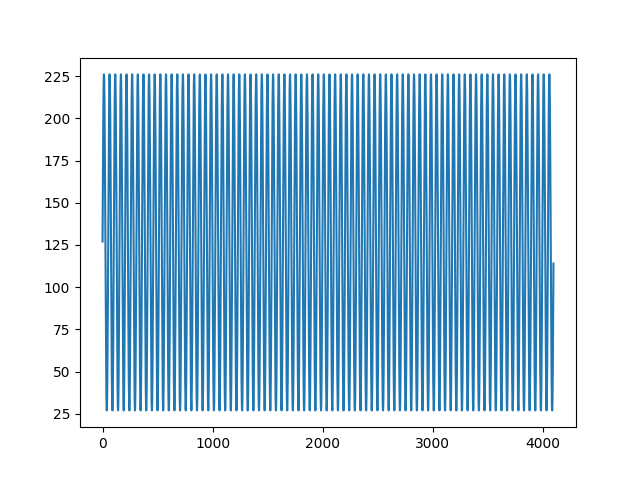

In [15]:
# ~20 kHz sine waveform
sineWave20k = wf.computeWaveform(waveformName = 'sine', 
                              frequencyHz = 19531,  # Why not 20e3 exactly?
                              amplitude = 200)

fig = plt.figure()
plt.plot(sineWave20k)
plt.show()

#### Frequency sweep in sinusoidal waveform
A sinusoidal waveform with a frequency sweep is generated. In this example, the range of frequencies are from 1 kHz to 50 kHz. 

The resulting waveform is stored in the variable ```sweep1k50k``` as an array (list) of 4096 integer elements.

The ```computeSweep``` method is used to synthesize this type of waveform.

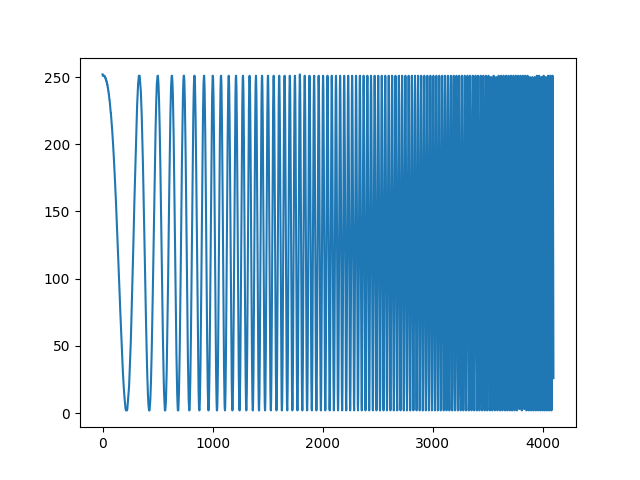

In [7]:
# Sinusoidal sweep from 1 kHz to 50 kHz
sweep1k50k = wf.computeSweep(freqStart = 1e3, freqEnd = 50e3, amplitude = 250)

fig = plt.figure()
plt.plot(sweep1k50k)
plt.show()

### Create your own waveforms

Now it's time for you to create the new waveforms using the provided library. Create a variable with the requested description in the following blocks. Keep using the same naming convention: for instance, a 12 kHz square waveform can be associated with the name ```sineWave12k```.

#### 5 kHz sinewave
Create a variable called ```sineWave5k``` containing a 5 kHz sine wave with the maximum DAC amplitude. Plot it in the same code block, so it can be easily inspected.

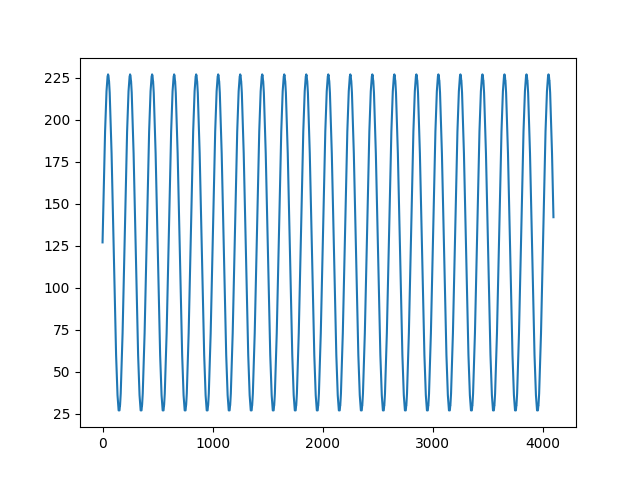

In [8]:
# 5 kHz sine waveform
sineWave5k = wf.computeWaveform(waveformName = 'sine', 
                              frequencyHz = 5e3,  # Why not 20e3 exactly?
                              amplitude = 200)

fig = plt.figure()
plt.plot(sineWave5k)
plt.show()

#### 10 kHz sawtooth waveform

Create a variable called ```sawtoothWave10k``` assigned to a 10 kHz sawtooth waveform and 200 amplitude units. Plot it in the same code block, so it can be easily inspected.

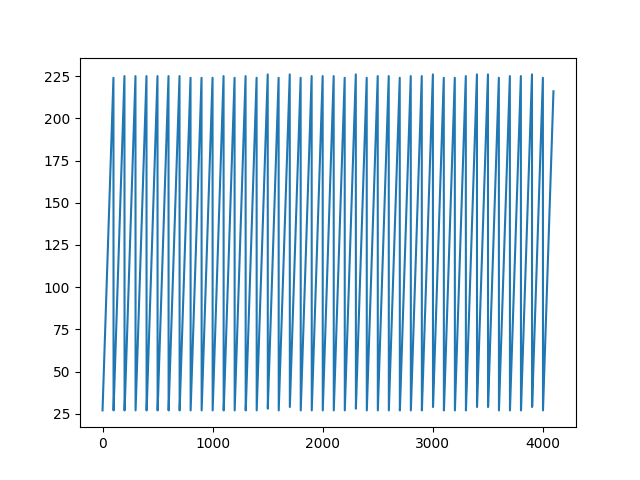

In [29]:
# 10 kHz sawtooth waveform
sawtoothWave10k = wf.computeWaveform(waveformName = 'sawtooth', 
                              frequencyHz = 10e3,  # Why not 20e3 exactly?
                              amplitude = 200)

fig = plt.figure()
plt.plot(sawtoothWave10k)
plt.show()

#### 16384 Hz square waveform

Create a variable called ```squareWave16k``` assigned to a 16384 Hz square waveform and 128 amplitude units. Plot it in the same code block, so it can be easily inspected.

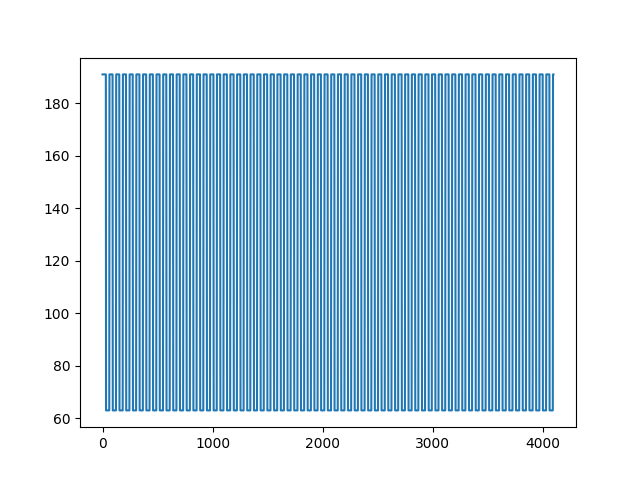

In [34]:
# 16384 Hz square waveform
# 10 kHz sawtooth waveform
squareWave16k = wf.computeWaveform(waveformName = 'square', 
                              frequencyHz = 16384,  # Why not 20e3 exactly?
                              amplitude = 128)

fig = plt.figure()
plt.plot(squareWave16k)
plt.show()

#### Additive white Gaussian noise (AWGN) with $\sigma = 60$

Create a variable called ```awgnSigma60``` to represent white noise with an std = 60 units. Due to the nature of the white noise, no frequency range or limit parameters are required. Plot the waveform in the same code block, so it can be easily inspected.

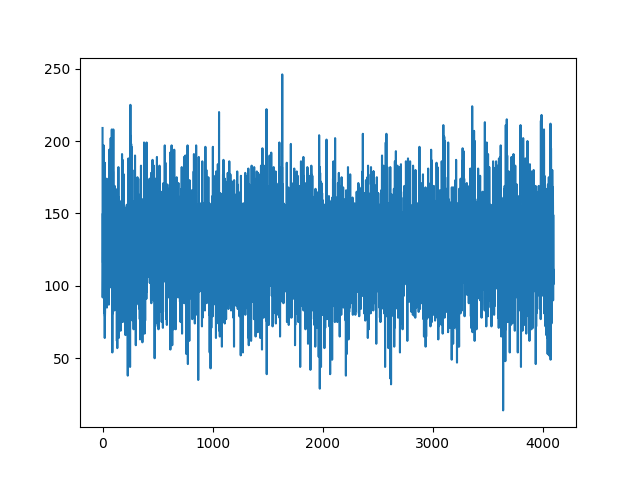

In [13]:
# Additive white Gaussian noise with sigma = 60
awgnSigma60 = wf.computeWaveform(waveformName = 'noise', 
                              amplitude = 60)

fig = plt.figure()
plt.plot(awgnSigma60)
plt.show()

##### Summary of generated waveforms

At this point, you should be able to use the waveforms described in the following table

**Table 1  - Synthesized waveforms**
| Variable Name     | Description |
| ----------- | ----------- |
| ```sineWave20k```     | ~20 kHz sinusoidal waveform |
| ```sweep1k50k```      | Sinusoidal frequency sweep 1 kHz -> 50 kHz|
| ```sineWave5k```      | 5 kHz sinusoidal waveform |
| ```sawtoothWave10k``` | 10 kHz sawtooth waveform |
| ```squareWave16k```   | 16384 Hz square waveform |
| ```awgnSigma60```     | Additive white Gaussian noise with $\sigma = 60$ |


---

# 2) Interfacing with hardware via UDMA
In this section you will make use of the synthesized waveforms from the last section to periodically execute the following loop:

- Transmit a synthesized waveform to the ComBlock's RAM using the UDMA.
- The hardware design in the PL of the SoC will continuously send these samples to the DAC (plugged into the ZedBoard's PMOD connector), so they get translated to the analog domain.
- This analog signal will be continuously sampled by the ADC (also plugged into the ZedBoard PMOD connector).
- The sampled values from the ADC stream will feed the input of the finite impulse response (FIR) filter that was generated with High-Level Synthesis (HLS).
- The output of the FIR filter will be stored in the ComBlock's input FIFO.
- The data stored in the FIFO will be sent from the SoC to this computer using UDMA.

## Setting up UDMA and ZedBoard parameters

IP Address and port of your ZedBoard development board

In [16]:
IP_ADDRESS = '192.168.1.10' # Set your ZedBoard IP Address here
IP_PORT = 7

Initializing UDMA class instance with provided IP settings

In [17]:
zedBoard = udma.UDMA_CLASS(IP_ADDRESS, IP_PORT)

### Connecting to ZedBoard

Tries indefinitely until connection is successful

In [18]:
connectionStatus = 0
while(connectionStatus == 0):
    connectionStatus = zedBoard.connect()
    time.sleep(1)

In [19]:
# Disable unused logging to speed up data transactions
_ = zedBoard.log(0)

## Interacting with ZedBoard via UDMA

### Transmit waveform to ComBlock's DP-RAM

Transmitting to ComBlock's DP-RAM the waveform array (vector). This step only performed once: the hardware design in the PL will take care to indefinitely loop through the waveform samples and push the them out to the DAC.

Feel free to exchange the waveform variable, choosing from those ones you synthesized in the previous section.

🔴 The next code block is where you **set the waveform** to be looped in the hardware 🔴

In [20]:
# Writing to ComBlock's RAM one of the provided waveforms (detailed in Table 1)

zedBoard.write_ram(addr = 0,
                   offset = 0,
                   length = TRACE_LEN,
                   inc = 1,
                   TxData = sineWave20k) # <--- This is the waveform variable that will be sent


[(1, 4096), 0]

### Verifying RAM contents
The waveform that was sent in the previous step must be already present in the ComBlock's DP-RAM

In [21]:
waveformStoredInRam = zedBoard.read_ram(0, TRACE_LEN, 1)[1]

Plotting the contents read from the ComBlock's DP-RAM

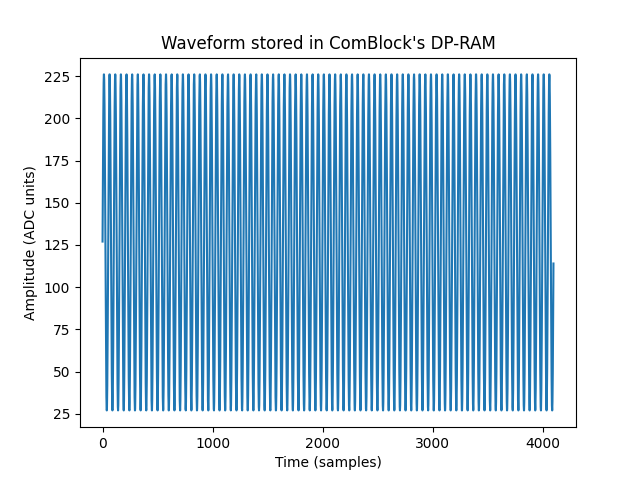

In [22]:
fig = plt.figure()
plt.title("Waveform stored in ComBlock's DP-RAM")
plt.xlabel("Time (samples)")
plt.ylabel("Amplitude (ADC units)")
plt.plot(waveformStoredInRam, '-', markersize = 1)
plt.show()

## Sampling analog signal and processing using the FIR filter
Dataflow (in SoC PL) to sample the data:
- Data are sampled from the ADC and sent to an AXI-Stream interface to the FIR filter
- Digitized data are processed in FIR filter
- Processed data captured in Comblock's input FIFO
- Data from ComBlock's FIFO are fetched via UDMA to this Jupyter Notebook

In [23]:
# Setting up the configuration bits of the DAC to enable output
zedBoard.write_reg(2, 0x20) # Set DAC control bits

[(1, 0), 0]

Enabling writing and reading to/from DAC+ADC

In [24]:
zedBoard.write_reg(0, 0x01) # Enable ADC operation
zedBoard.write_reg(1, 0x01) # Enable DAC operation

[(1, 0), 0]

In [25]:
# Function definition: used to clear out iFIFO contents prior to read any value
def clearInFifo(udmaInstance):
    udmaInstance.write_reg(17, 1)
    udmaInstance.write_reg(17, 0)

### Acquisition from Comblock's FIFO using UDMA

Here you will fetch the latest data from the FIR filter output using DMA. Execute this block as many times as you want (```Ctrl+Enter```) to observe the results in the time domain.

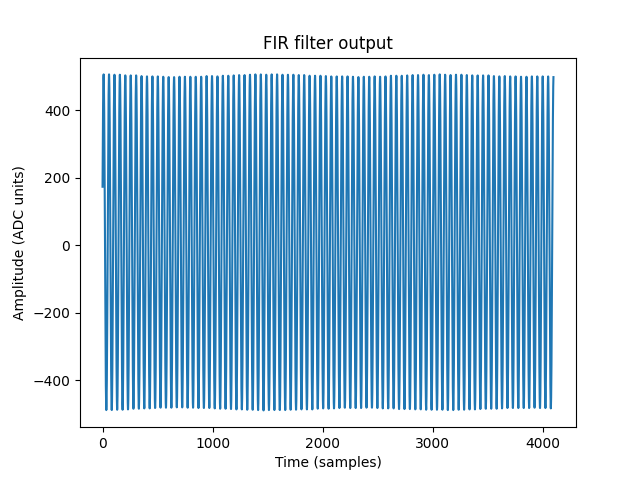

In [26]:
# Clear input FIFO contents to get the latest data from the FIR filter output
clearInFifo(zedBoard)

# Empty list declaration: the data read from the ComBlock's FIFO will be stored here
fifoInputTrace = []

# Fetching data from ComBlock's FIFO in chunks to avoid TCP segmentation
for i in range(TRACE_SEGMENTS):
    fifoSamples = zedBoard.read_fifo(CHUNK_SIZE)[1]
    
    # Matching the numerical representation of the FIR filter output (integer 16 bits)
    fifoSamples = np.array(fifoSamples).astype(np.int16)
    
    # Appending to the result array the latest data read from FIFO
    fifoInputTrace.extend(fifoSamples)


# Plotting the acquired trace (FIR output)
fig = plt.figure()
plt.plot(fifoInputTrace)
plt.title("FIR filter output")
plt.xlabel("Time (samples)")
plt.ylabel("Amplitude (ADC units)")
plt.show()


---

# 3) Data analysis with Python
In this section you will be introduced to a simple analysis for the captured traces, resulting from the FIR filter output data.

The Fast Fourier Transform (FFT) algorithm will be used to translate the sampled data into the frequency domain. This will allow you to easily visualize the response of the filter to the input waveform used as the stimulus (synthesized waveform). 

The power spectral density (PSD) plot will be created, representing the power density contents of the retrieved signal for each frequency component. The sampling frequency is constant ($f_s$ = 1 MHz), allowing for an easy translation of the analog frequency representation in the PSD plot.

## Power spectral density (PSD) of the filter output

Observe how the filter output changes when testing with different the stimuli (synthesized waveforms). 
- Test different waveforms as stimuli of the FIR filter using the UDMA code in section 2
  - Notice that even with the filter, harmonics will appear for sawtooth and square waveforms
  - Although the noise trace should be much longer to emulate a plain spectrum, observe the behavior after the FIR output
- Test the frequency sweep as the stimulus to assess the frequency response of the FIR filter
  - Compare this result to the [frequency parameters of the filter](https://gitlab.com/ictp-mlab/smr-3891/-/wikis/Labs/Lab-4-ADC-DAC-loopback-and-TCL#131-hls-based-fir-ip-core) exposed in the Lab Guide:
    - Frequency ranges
    - Gain at pass and rejection bands
    - Ripple at pass band


You can also play around with composite waveforms: you may take two or more signals and sum them up or even multiply them (AM modulation). Just be careful to normalize the outputs to the maximum DAC output value ($2^8 - 1$).

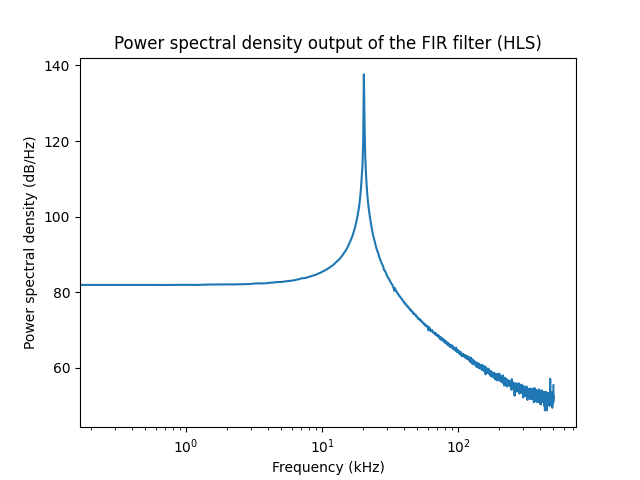

In [27]:
import scipy.fft

# Creating the x-axis of the plot (frequency axis in kHz scale)
fftLen = TRACE_LEN//2
xAxis = np.linspace(0, (SAMPLING_RATE//2)/1000, fftLen)

# Computing the FFT magnitude to obtain the PSD (in dB/Hz)
psdMagnitude = np.abs(scipy.fft.fft(fifoInputTrace))[:fftLen]
psdMagnitude = 10*np.log(psdMagnitude)

# Plotting the filter output in the frequency domain
fig = plt.figure()
plt.plot(xAxis, psdMagnitude)

plt.title("Power spectral density output of the FIR filter (HLS)")
plt.xlabel('Frequency (kHz)')
plt.ylabel('Power spectral density (dB/Hz)')
plt.xscale('log')
plt.show()


---

## Use of UDMA with Chirp waveform

**Table 1  - Synthesized waveforms**
| Variable Name     | Description |
| ----------- | ----------- |
| ```sineWave20k```     | ~20 kHz sinusoidal waveform |
| ```sweep1k50k```      | Sinusoidal frequency sweep 1 kHz -> 50 kHz|
| ```sineWave5k```      | 5 kHz sinusoidal waveform |
| ```sawtoothWave10k``` | 10 kHz sawtooth waveform |
| ```squareWave16k```   | 16384 Hz square waveform |
| ```awgnSigma60```     | Additive white Gaussian noise with $\sigma = 60$ |



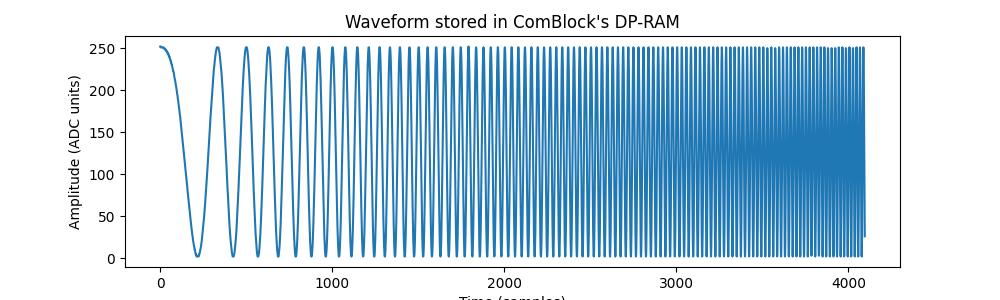

[(1, 0), 0]

In [41]:
# Writing to ComBlock's RAM one of the provided waveforms (detailed in Table 1)

zedBoard.write_ram(addr = 0,
                   offset = 0,
                   length = TRACE_LEN,
                   inc = 1,
                   TxData = sweep1k50k) # <--- This is the waveform variable that will be sent

waveformStoredInRam = zedBoard.read_ram(0, TRACE_LEN, 1)[1]

fig = plt.figure(figsize=(10,3))
plt.title("Waveform stored in ComBlock's DP-RAM")
plt.xlabel("Time (samples)")
plt.ylabel("Amplitude (ADC units)")
plt.plot(waveformStoredInRam, '-', markersize = 1)
plt.show()


# Setting up the configuration bits of the DAC to enable output
zedBoard.write_reg(2, 0x20) # Set DAC control bits

zedBoard.write_reg(0, 0x01) # Enable ADC operation
zedBoard.write_reg(1, 0x01) # Enable DAC operation


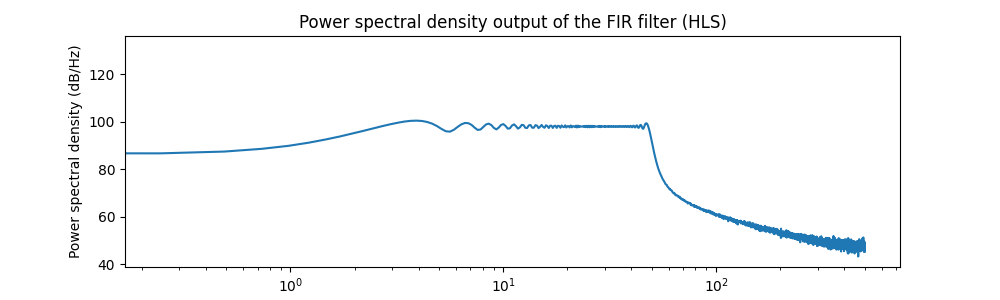

In [42]:
# Creating the x-axis of the plot (frequency axis in kHz scale)
fftLen = TRACE_LEN//2
xAxis = np.linspace(0, (SAMPLING_RATE//2)/1000, fftLen)

# Computing the FFT magnitude to obtain the PSD (in dB/Hz)
psdMagnitude = np.abs(scipy.fft.fft(waveformStoredInRam))[:fftLen]
psdMagnitude = 10*np.log(psdMagnitude)

# Plotting the filter output in the frequency domain
fig = plt.figure(figsize=(10,3))
plt.plot(xAxis, psdMagnitude)

plt.title("Power spectral density output of the FIR filter (HLS)")
plt.xlabel('Frequency (kHz)')
plt.ylabel('Power spectral density (dB/Hz)')
plt.xscale('log')
plt.show()

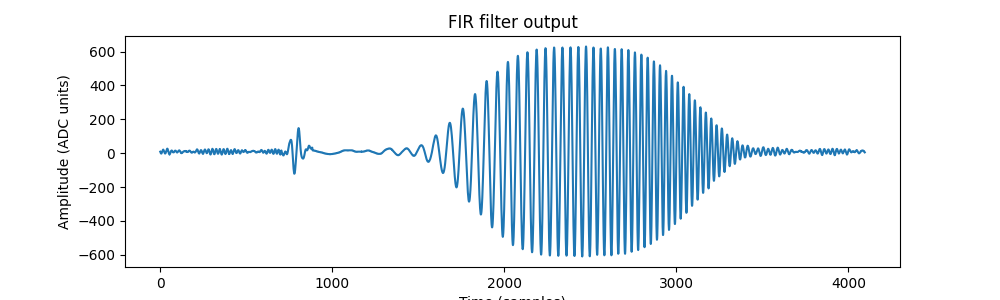

In [43]:
# Clear input FIFO contents to get the latest data from the FIR filter output
clearInFifo(zedBoard)

# Empty list declaration: the data read from the ComBlock's FIFO will be stored here
fifoInputTrace = []

# Fetching data from ComBlock's FIFO in chunks to avoid TCP segmentation
for i in range(TRACE_SEGMENTS):
    fifoSamples = zedBoard.read_fifo(CHUNK_SIZE)[1]
    
    # Matching the numerical representation of the FIR filter output (integer 16 bits)
    fifoSamples = np.array(fifoSamples).astype(np.int16)
    
    # Appending to the result array the latest data read from FIFO
    fifoInputTrace.extend(fifoSamples)


# Plotting the acquired trace (FIR output)
fig = plt.figure(figsize=(10,3))
plt.plot(fifoInputTrace)
plt.title("FIR filter output")
plt.xlabel("Time (samples)")
plt.ylabel("Amplitude (ADC units)")
plt.show()


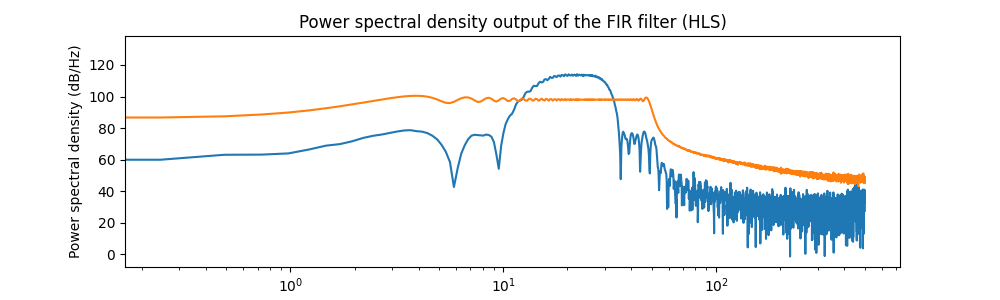

In [44]:
# Creating the x-axis of the plot (frequency axis in kHz scale)
fftLen = TRACE_LEN//2
xAxis = np.linspace(0, (SAMPLING_RATE//2)/1000, fftLen)

# Computing the FFT magnitude to obtain the PSD (in dB/Hz)
psdMagnitude = np.abs(scipy.fft.fft(fifoInputTrace))[:fftLen]
psdMagnitude = 10*np.log(psdMagnitude)
psdMagnitude2 = np.abs(scipy.fft.fft(waveformStoredInRam))[:fftLen]
psdMagnitude2 = 10*np.log(psdMagnitude2)

# Plotting the filter output in the frequency domain
fig = plt.figure(figsize=(10,3))
plt.plot(xAxis, psdMagnitude)
plt.plot(xAxis, psdMagnitude2)

plt.title("Power spectral density output of the FIR filter (HLS)")
plt.xlabel('Frequency (kHz)')
plt.ylabel('Power spectral density (dB/Hz)')
plt.xscale('log')
plt.show()

# 4) Challenge

Once you have had the chance to verify how to perform the UDMA interaction with the hardware, two challenge exercises are proposed, sorted in increasing difficulty.

Refer to the [Lab Guide](https://gitlab.com/ictp-mlab/smr-3891/-/wikis/Labs/Lab-4-ADC-DAC-loopback-and-TCL#6-challenge) for the detailed requirements:
- Challenge 1 - Create the [bode magnitude plot](https://en.wikipedia.org/wiki/Bode_plot) of the filter response
  - Hint: synthesize multiple sine waveforms with same amplitude and different frequencies
- Challenge 2 - Modify the FIR filter parameters to achieve different frequency response using the High-level synthesis source files
  - Hint: you may use the [TFilter tool](http://t-filter.engineerjs.com/) to generate the coefficients
